# 🧠 Clasificación de imágenes de componentes de PC

### 👨‍💻 Autores del proyecto

* [Alejandro Barrionuevo Rosado](https://github.com/Alejandro-BR)
* [Alvaro López Guerrero](https://github.com/Alvalogue72)
* [Andrei Munteanu Popa](https://github.com/andu8705)

<img src="https://github.com/Latency-Zero-tfm/HardVisionAI/blob/main/img/portada.png?raw=true" width=55%>

Máster de FP en Inteligencia Artifical y Big Data - CPIFP Alan Turing - `Curso 2025/2026`

El objetivo principal de este cuaderno es utilizar el conjunto de datos `components_03.csv`, obtenido tras el preprocesamiento realizado en el cuaderno Jupyter anterior (`dataset_processing.ipynb`). A partir de este dataset, se procesarán las imágenes mediante su redimensionamiento y vectorización para entrenar un modelo de deep learning basado en redes neuronales.

El propósito final es lograr la mayor precisión posible, de modo que el modelo sea capaz de reconocer imágenes de componentes de ordenador e clasificar cada tipo de componente o hardware de un ordenador.

### Importación de paquetes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from tensorflow import keras

## Obtención de datos

Para el entrenamiento del modelo se utilizará el conjunto de datos `components_03.csv`, obtenido mediante web scraping y su posterior limpieza y procesamiento, realizados en los cuadernos Jupyter que se encuentran en nuestro repositorio.


In [4]:
df = pd.read_csv('../data/processed/components_03.csv')
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   local_image_path  9971 non-null   str  
 1   label             9971 non-null   int64
dtypes: int64(1), str(1)
memory usage: 155.9 KB


## Descripción de los datos

El dataset cuenta con  **2 columnas**, de las cuales `label` es de tipo `int64` e `local_image_path` es de tipo `str`, ya que contiene las rutas locales que identifican a cada uno de los componentes de.

| Columna | Tipo   | Descripción                                        |
| ------- | ------ | -------------------------------------------------- |
| local_image_path   | object | Rutas locales de las imágenes de cada componente   |
| label   | int64  | Etiqueta numérica que indica el tipo de componente |

In [16]:
df.head()

,local_image_path,label
0,../data/images/motherboard_0.jpg,0
1,../data/images/motherboard_1.jpg,0
2,../data/images/motherboard_2.jpg,0
3,../data/images/motherboard_3.jpg,0
4,../data/images/motherboard_4.jpg,0


## Exposición del objetivo

El **target** que se busca predecir es el **label**, es decir, el tipo de componente. Por tanto tenemos **11 clases** las cuáles son las siguientes:

| Número | Componente     |
| ------ | -------------- |
| 0      | motherboard    |
| 1      | gpu            |
| 2      | cpu            |
| 3      | hard_drive     |
| 4      | ram            |
| 5      | pc_case        |
| 6      | power_supply   |
| 7      | liquid_cooling |
| 8      | case_fan       |
| 9      | cpu_fan        |
| 10     | sound_card     |

Defifnimos un diccionario que asocia cada número de etiqueta (`label`) con el nombre del componente correspondiente, para facilitar la interpretación de los resultados y la visualización de los datos en gráficos posteriores.

In [17]:
label_map = {
    0: 'motherboard',
    1: 'gpu',
    2: 'cpu',
    3: 'hard_drive',
    4: 'ram',
    5: 'pc_case',
    6: 'power_supply',
    7: 'liquid_cooling',
    8: 'case_fan',
    9: 'cpu_fan',
    10: 'sound_card'
}

## Visualización de los datos

### Distribución de imágenes por tipo de componente

En nuestro conjunto de casi 10,000 imágenes, la distribución por tipo de componente muestra una variedad relativamente equilibrada entre varias categorías, aunque con algunas diferencias destacables. Por ejemplo, los componentes como el **disco duro** y la **caja del PC** representan una proporción considerablemente mayor (19.0% y 18.3%, respectivamente), mientras que otros como la **tarjeta de sonido** apenas alcanzan el 0.5%.  

Estas variaciones reflejan una presencia más frecuente de ciertos componentes en el conjunto de datos, lo que está relacionado con su disponibilidad visual o relevancia técnica.


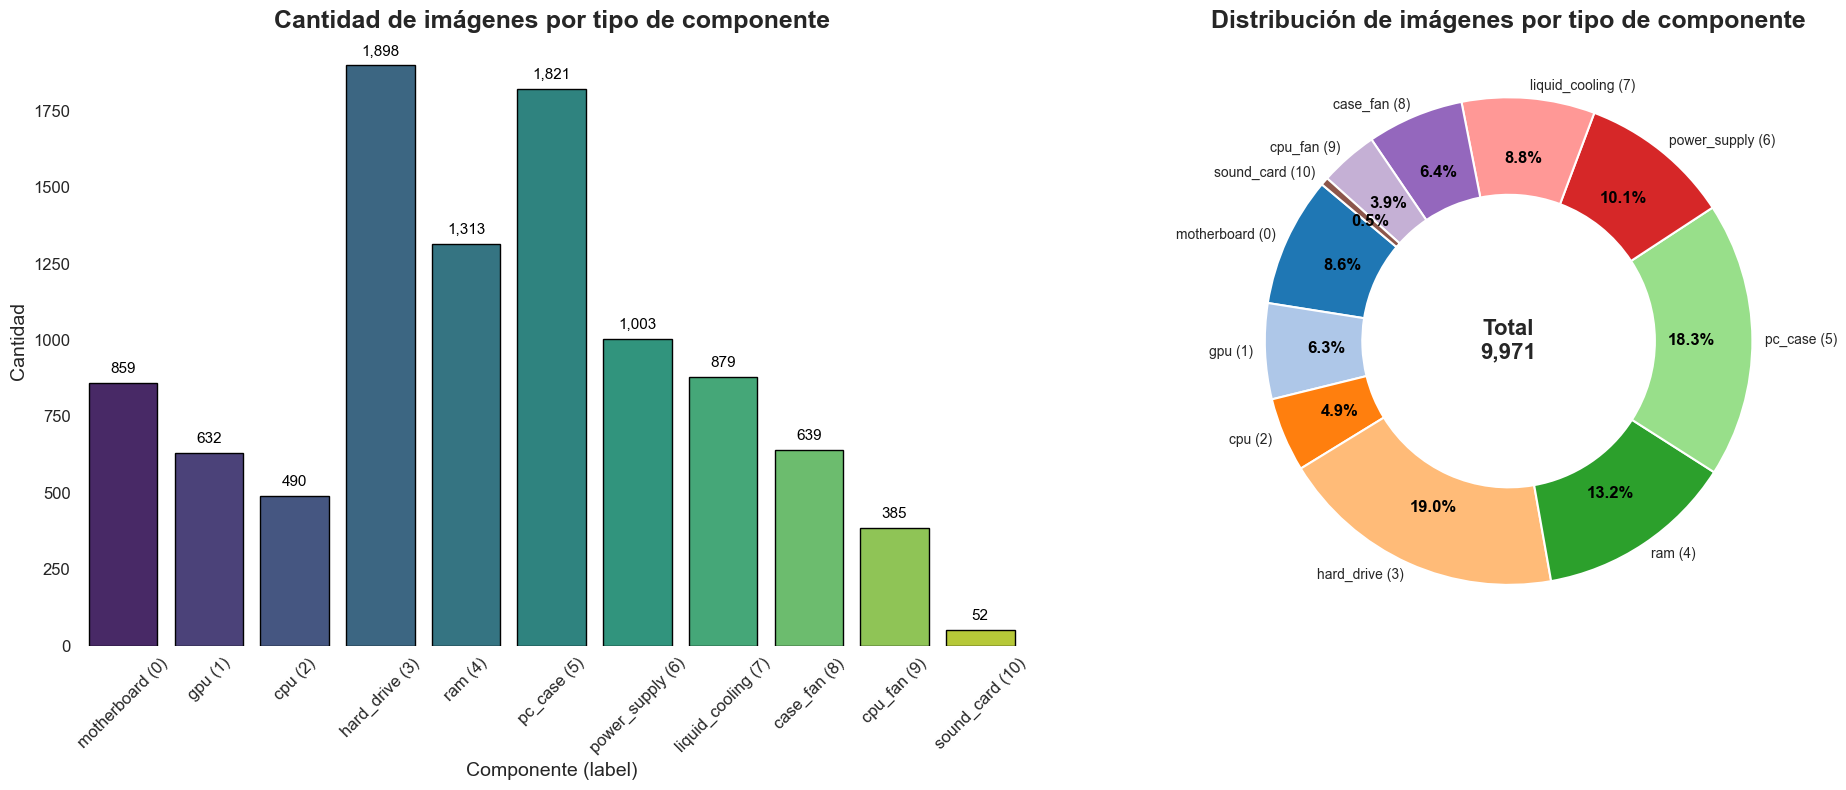

In [18]:
label_counts = df["label"].value_counts().sort_index().reset_index()
label_counts.columns = ["label", "count"]
label_counts["label_display"] = label_counts["label"].map(label_map) + " (" + label_counts["label"].astype(str) + ")"

labels = label_counts["label_display"]
sizes = label_counts["count"]
total_images = sizes.sum()
colors = plt.cm.tab20.colors[:len(labels)]

sns.set_style("white")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

barplot = sns.barplot(
    x="label_display",
    y="count",
    data=label_counts,
    hue="label_display",
    palette="viridis",
    edgecolor="black",
    legend=False,
    ax=axes[0]
)

for patch in barplot.patches:
    height = patch.get_height()
    barplot.annotate(
        f"{int(height):,}",
        (patch.get_x() + patch.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=11,
        color="black",
        xytext=(0, 5),
        textcoords="offset points"
    )

axes[0].set_title("Cantidad de imágenes por tipo de componente", fontsize=18, weight="bold")
axes[0].set_xlabel("Componente (label)", fontsize=14)
axes[0].set_ylabel("Cantidad", fontsize=14)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
sns.despine(ax=axes[0], left=True, bottom=True)

wedges, texts, autotexts = axes[1].pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    wedgeprops={"width":0.4, "edgecolor":"white", "linewidth":1.5},
    pctdistance=0.75,
    labeldistance=1.05
)

for autotext in autotexts:
    autotext.set_color("black")
    autotext.set_fontsize(12)
    autotext.set_weight("bold")

axes[1].text(0, 0, f"Total\n{total_images:,}", ha="center", va="center", fontsize=16, weight="bold")
axes[1].set_aspect("equal")
axes[1].set_title("Distribución de imágenes por tipo de componente", fontsize=18, weight="bold")

plt.tight_layout()
plt.show()


## Preparación de los datos

### Mezcla de datos

Se mezclan aleatoriamente las filas del DataFrame para evitar que el orden de los datos influya en el entrenamiento del modelo, para asegurar que la partición en conjuntos de entrenamiento y validación sea representativa.

In [5]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,local_image_path,label
0,../data/images/ram_3356.jpg,4
1,../data/images/hard_drive_2406.jpg,3
2,../data/images/ram_4376.jpg,4
3,../data/images/motherboard_107.jpg,0
4,../data/images/cpu_9398.jpg,2
...,...,...
9966,../data/images/pc_case_5739.jpg,5
9967,../data/images/pc_case_5195.jpg,5
9968,../data/images/pc_case_5395.jpg,5
9969,../data/images/gpu_861.jpg,1


### Procesamiento y vectorización de imágenes

En esta celda se define una función para cargar, redimensionar y vectorizar las imágenes a partir de las rutas almacenadas en el DataFrame. Se generan dos conjuntos de datos: uno en color y otro en escala de grises, esto es fundamental para preparar las imágenes como entrada al modelo de deep learning. Además separamos nuestro *target* `y_color` o `y_gray` de la matriz de características `X_color` o `X_gray`. (Se hacen ambas separaciones, color y escala de grises, para luego elegir la opción más efectiva y rentable para el entramiento del modelo).

Finalmente, para el entramiento del modelo en este mismo cuaderno Jupyter se ha escogido las imágenes en escalas de grises.

In [6]:
def process_images(df, path_column, width=230, height=230, grayscale=False):
    """Función para procesar imágenes desde rutas en un DataFrame, con opción de escala de grises."""
    images = []
    valid_indices = [] 

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        file_name = row[path_column] 
        full_path = os.path.join(file_name)
        
        if os.path.exists(full_path):
            img = cv2.imread(full_path)
            if img is not None:
                if grayscale:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img_resized = cv2.resize(img, (width, height))
                    img_resized = np.expand_dims(img_resized, axis=-1)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img, (width, height))
                images.append(img_resized)
                valid_indices.append(index)
            else:
                print(f"Aviso: no se pudo leer la imagen {file_name}")
        else:
            print(f"Aviso: Archivo no encontrado {full_path}")

    X = np.array(images, dtype='uint8')
    y_aligned = df.loc[valid_indices, "label"].values
    return X, y_aligned

# Para imágenes a color RGB
# X_color, y_color = process_images(df, 'local_image_path', grayscale=False)
# Para imágenes en escala de grises
X_gray, y_gray = process_images(df, 'local_image_path', grayscale=True)

# print("Shape imágenes color:", X_color.shape)
print("Shape imágenes gris:", X_gray.shape)

  0%|          | 0/9971 [00:00<?, ?it/s]

100%|██████████| 9971/9971 [00:56<00:00, 177.98it/s]


Shape imágenes gris: (9971, 230, 230, 1)


### Visualización de imágenes procesadas

Vamos a visualizar algunas imágenes para ver cómo están guardadas y cómo se verían. Para comprobar visualmente que el preprocesamiento se ha realizado correctamente y que las imágenes tienen el formato esperado.


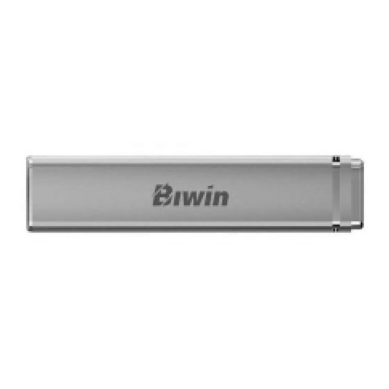

In [21]:
plt.imshow(X_gray[1], cmap='gray')
plt.axis("off")
plt.show()

Comprobamos que la etiqueta se corresponde con la imagen representada anteriormente.

In [ ]:
example_01 = label_map[y_gray[1]]
print("Etiqueta de la imagen del ejemplo 01:", example_01)

Etiqueta de la imagen de ejemplo 01: hard_drive


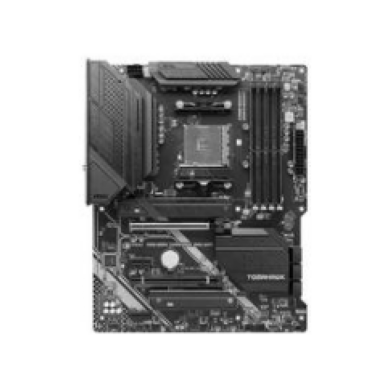

In [30]:
plt.imshow(X_gray[3121], cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
example_02 = label_map[y_gray[3121]]
print("Etiqueta de la imagen del ejemplo 02:", example_02)

Etiqueta de la imagen de ejemplo 02: motherboard


### División en conjuntos de entrenamiento y prueba

Procedemos a dividir los datos de imágenes y etiquetas en conjuntos de entrenamiento y prueba. Un 80% serán para los datos de entrenamiento y 20% para datos de prueba.

In [7]:
X_train_full, y_train_full, X_test, y_test = X_gray[:8000], y_gray[:8000], X_gray[8000:], y_gray[8000:]

### Normalización de imágenes

Se normalizan los valores de los píxeles de las imágenes de entrenamiento y del conjunto de prueba dividiéndolos por 255. Esto mejora la estabilidad y el rendimiento del modelo durante el entrenamiento.

In [8]:
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

### División del conjunto en entrenamiento y validación

Se separa una parte del conjunto de entrenamiento para usarlo como conjunto de validación. Esto permite monitorizar el rendimiento del modelo durante el entrenamiento y evitar el sobreajuste.

In [9]:
X_valid, X_train = X_train_full[:1000], X_train_full[1000:]

In [10]:
y_valid, y_train = y_train_full[:1000], y_train_full[1000:]

## Entrenamiento del modelo

### Definición de la arquitectura del modelo

Se construye la arquitectura de la red neuronal convolucional (CNN) utilizando Keras. El modelo incluye varias capas de convolución, normalización, pooling, y capas densas, finalizando con una capa softmax para clasificación multiclase.

In [ ]:
model = keras.models.Sequential([
    
    keras.layers.Input(shape=(230, 230, 1)),
    
    keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(11, activation="softmax")
])

In [136]:
# Resumen del modelo
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 230, 230, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 230, 230, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 115, 115, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 115, 115, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 115, 115, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 57, 57, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 57, 57, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,619 (111.79 KB)

 Trainable params: 28,395 (110.92 KB)

 Non-trainable params: 224 (896.00 B)

### Compilación del modelo

Se compila el modelo especificando la función de pérdida, el optimizador y las métricas a monitorizar. En este caso, se usa `sparse_categorical_crossentropy` para clasificación multiclase, el optimizador Adam y la métrica de precisión (`accuracy`).

In [137]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Callbacks para el entrenamiento

Se definen dos callbacks: `EarlyStopping` para detener el entrenamiento si la pérdida de validación no mejora, y `ReduceLROnPlateau` para reducir la tasa de aprendizaje si la pérdida de validación se estanca. Esto ayuda a optimizar el proceso de entrenamiento y evitar el sobreajuste.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,             # Si en 3 épocas no mejora la val_loss, se detiene
    restore_best_weights=True 
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1)

El historial de entrenamiento se almacena para su posterior análisis.

In [139]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.3511 - loss: 1.8621 - val_accuracy: 0.0580 - val_loss: 2.8193 - learning_rate: 0.0010
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.5037 - loss: 1.4463 - val_accuracy: 0.2240 - val_loss: 3.4536 - learning_rate: 0.0010
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.5969 - loss: 1.2248 - val_accuracy: 0.4090 - val_loss: 1.8735 - learning_rate: 0.0010
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.6626 - loss: 1.0523 - val_accuracy: 0.5110 - val_loss: 1.7055 - learning_rate: 0.0010
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.7071 - loss: 0.9277 - val_accuracy: 0.3960 - val_loss: 2.0381 - learning_rate: 0.0010
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.7359 - loss: 0.8656 - val_accuracy: 0.6270 - val_loss: 1.1780 - learning_rate: 0.0010
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.7590 - loss: 0.

## Comprobación del redimiento

### Visualización del rendimiento del entrenamiento

Se grafican las métricas de entrenamiento y validación (pérdida y precisión) a lo largo de las épocas para analizar el comportamiento del modelo y detectar posibles problemas como sobreajuste o bajo aprendizaje.

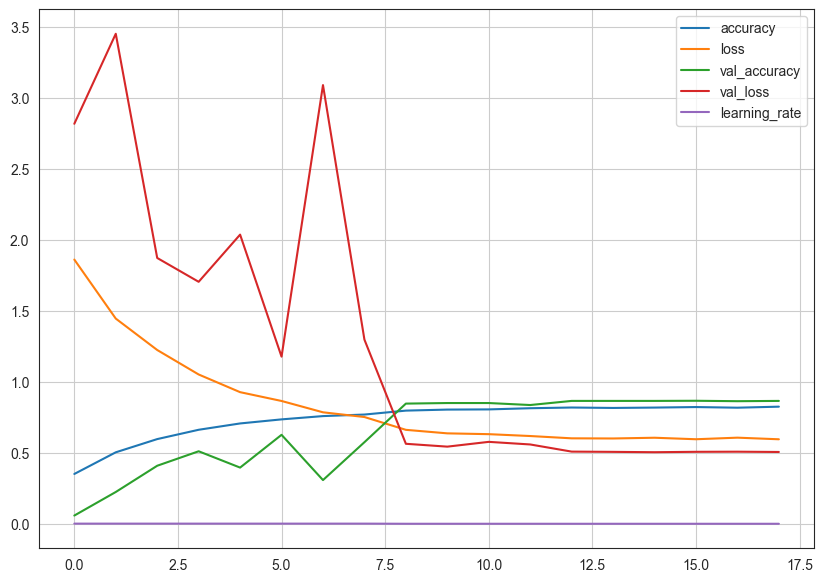

In [140]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid()
plt.show()

### Evaluación del modelo

Se evalúa el modelo entrenado utilizando el conjunto de prueba, obteniendo métricas de rendimiento como la pérdida y la precisión sobre datos no vistos durante el entrenamiento. Se utiliza `X_test` y `y_test` para ello.

In [ ]:
score = model.evaluate(X_test, y_test)
score

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.8524 - loss: 0.5073


[0.5072921514511108, 0.8523592352867126]

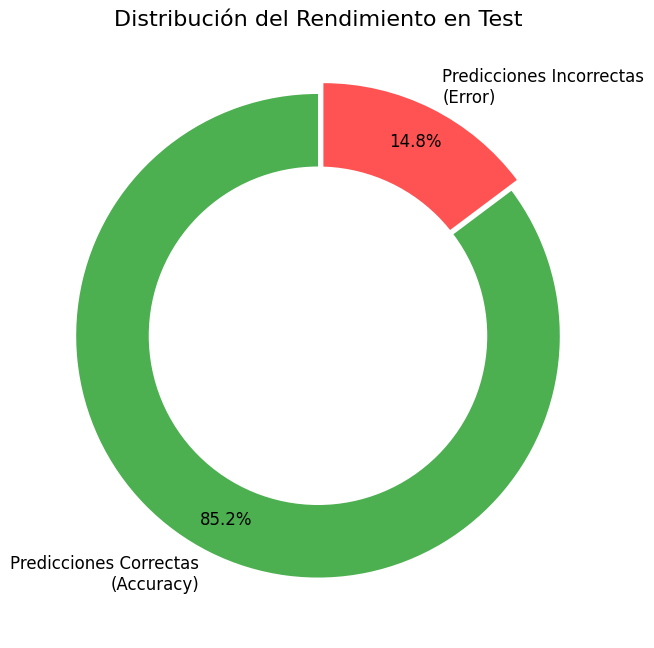

In [14]:
accuracy = score[1]
error = 1.0 - accuracy

labels = ['Predicciones Correctas\n(Accuracy)', 'Predicciones Incorrectas\n(Error)']
sizes = [accuracy, error]

colors = ['#4CAF50', '#FF5252']
explode = (0, 0.05)

plt.figure(figsize=(7, 7))
plt.pie(sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        explode=explode,
        pctdistance=0.85,
        textprops={'fontsize': 12})

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribución del Rendimiento en Test', fontsize=16)
plt.tight_layout()
plt.show()

### Predicción sobre imágenes del conjunto de test

Se seleccionan algunas imágenes del conjunto de prueba y se obtienen las predicciones del modelo para analizar su comportamiento y comprobar la salida de la red neuronal. Además de representarán las imágenes de esos registros para compbrar el rendimiento del modelo.

Obtenemos la predicción de los 6 primeros registros de nuestro conjunto de pruebas.

In [ ]:
X_new = X_test[:6]
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Miramos las probabilidades que le ha asignado el modelo a cada una de las clases de nuestro target para las 6 primeras imágenes.

In [49]:
y_pred

array([[6.6211607e-05, 1.5450577e-01, 5.4025371e-04, ..., 9.7903378e-02,
        1.5314503e-02, 8.6073708e-03],
       [1.1985852e-06, 6.8774207e-06, 1.5880341e-03, ..., 4.2054362e-05,
        7.9369645e-05, 3.3863598e-05],
       [8.2785308e-01, 1.6764864e-01, 2.4000935e-06, ..., 7.6683878e-05,
        1.2567228e-03, 2.8705801e-06],
       ...,
       [4.8299436e-04, 1.7409526e-02, 1.0984470e-03, ..., 1.4674281e-02,
        1.8463422e-03, 2.1894980e-02],
       [5.5010635e-01, 5.6743499e-02, 8.5523734e-03, ..., 1.3935739e-03,
        2.8359666e-03, 1.7615717e-03],
       [4.8299436e-04, 1.7409526e-02, 1.0984470e-03, ..., 1.4674281e-02,
        1.8463422e-03, 2.1894980e-02]], shape=(656, 11), dtype=float32)

Obtemos el índice de la probabilidad más alta que le ha asignado el modelo a cada uno de los registros de los que hemos hecho la predicción.

In [52]:
y_max_pred = np.argmax(y_pred, axis=1)

In [53]:
y_max_pred

array([9, 8, 6, 3, 7, 3])

Ahora representaremos las imágenes de los 6 registros y se mostrará por pantalla la clase asignada para cada uno de ellos, que ha predicho el modelo.

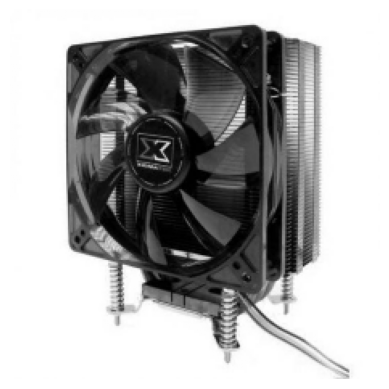

In [54]:
test_0 = X_new[0]
plt.imshow(test_0, cmap='gray')
plt.axis("off")
plt.show()

In [61]:
test_0 = label_map[y_max_pred[0]]
print("El componente de la imágen 0, según el modelo es:", test_0)

El componente de la imágen 0, según el modelo es: cpu_fan


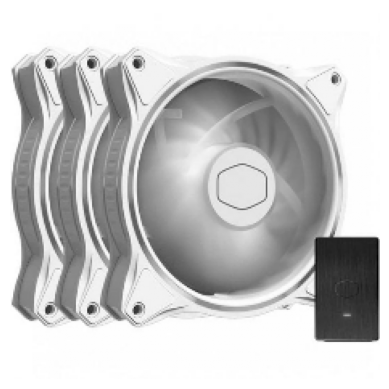

In [56]:
test_1 = X_new[1]
plt.imshow(test_1, cmap='gray')
plt.axis("off")
plt.show()

In [62]:
test_1 = label_map[y_max_pred[1]]
print("El componente de la imágen 1, según el modelo es:", test_1)

El componente de la imágen 1, según el modelo es: case_fan


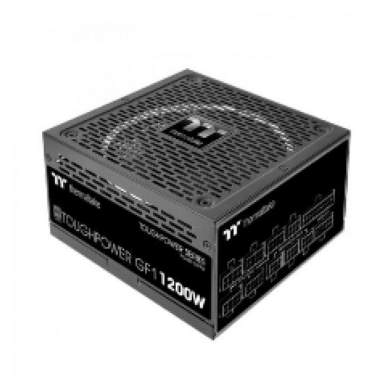

In [59]:
test_2 = X_new[2]
plt.imshow(test_2, cmap='gray')
plt.axis("off")
plt.show()

In [63]:
test_2 = label_map[y_max_pred[2]]
print("El componente de la imágen 2, según el modelo es:", test_2)

El componente de la imágen 2, según el modelo es: power_supply


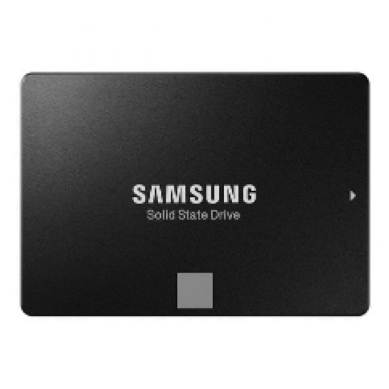

In [64]:
test_03 = X_new[3]
plt.imshow(test_03, cmap='gray')
plt.axis("off")
plt.show()

In [65]:
test_3 = label_map[y_max_pred[3]]
print("El componente de la imágen 3, según el modelo es:", test_3)

El componente de la imágen 3, según el modelo es: hard_drive


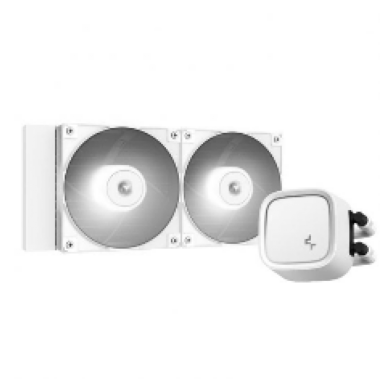

In [66]:
test_4 = X_new[4]
plt.imshow(test_4, cmap='gray')
plt.axis("off")
plt.show()

In [67]:
test_4 = label_map[y_max_pred[4]]
print("El componente de la imágen 4, según el modelo es:", test_4)

El componente de la imágen 4, según el modelo es: liquid_cooling


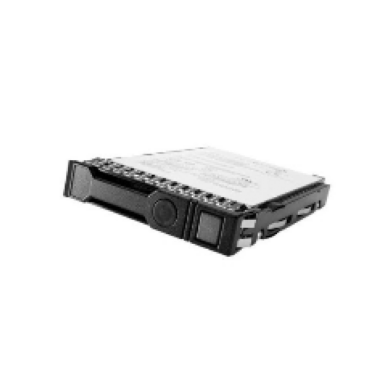

In [68]:
test_5 = X_new[5]
plt.imshow(test_5, cmap='gray')
plt.axis("off")
plt.show()

In [69]:
test_5 = label_map[y_max_pred[5]]
print("El componente de la imágen 5, según el modelo es:", test_5)

El componente de la imágen 5, según el modelo es: hard_drive


## Guardar el modelo

Se guarda el modelo entrenado en formato `.keras` para poder reutilizarlo posteriormente sin necesidad de volver a entrenar desde cero.

In [143]:
# Guardar el modelo
model.save('../models/components_pc_model.keras')

## Conclusiones

### Evolución del Entrenamiento

El modelo se entrenó durante **18 épocas** antes de que el *Early Stopping* detuviera el proceso para evitar el sobreajuste.

* **Punto de inflexión:** Al inicio (Época 1), el modelo apenas tenía una precisión del **35%**. Sin embargo, se observa una mejora drástica en la **Época 9**, coincidiendo con la primera reducción automática de la tasa de aprendizaje (*Learning Rate*).

**Métricas Finales:**
* **Precisión de entrenamiento:** ~82.5%
* **Precisión de validación:** **86.6%**
* **Pérdida (Loss) de validación:** 0.5061


### Evaluación con Datos de Prueba (Test)

Al evaluar el modelo con el conjunto de datos de prueba (`x_test`), los resultados confirman su solidez:

* **Precisión en Test (Accuracy):** **85.24%**
* **Pérdida en Test:** 0.5073
* **Interpretación:** Una precisión del 85% en un problema de 11 categorías.

### Análisis de General

* **Eficacia del Optimizador:** El uso de `ReduceLROnPlateau` permitió que, cuando el modelo dejó de mejorar con la tasa de aprendizaje inicial, se realizaran ajustes más finos (bajando de  a  y finalmente a ), lo que permitió "pulir" la precisión en las últimas etapas.

* **Robustez:** El modelo es capaz de manejar la descompensación en el dataset (donde algunas categorías tenían muy pocas imágenes, como las tarjetas de sonido) sin perder eficacia global.
* **Eficiencia:** Al procesar las imágenes en **escala de grises**, el modelo logra estos resultados con una arquitectura eficiente de 3 capas convolucionales, lo que permite predicciones rápidas incluso en hardware no especializado.